In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import pickle

In [2]:
# b attenuation coefficients from Martin (1987), Henson (2012) and Guidi (2015)
martin = scipy.io.loadmat('data/b_attenuation/B_martin.mat')
b_guidi = martin['B_Guidi']
b_henson = martin['B_Henson']

In [3]:
# extract and clean Henson and Guidi's data
henson = scipy.io.loadmat('data/Henson/expHensonmod.mat')
latH = np.concatenate(henson['lat'])
lonH = np.concatenate(henson['lon'])
export = henson['exportC']

# need to add 8 latitudes points so that latH goes from -89.5 to 89.5, otherwise, the interpolation with Tim will be translated downwards
add_latH = np.array([-82.5,-83.5,-84.5,-85.5,-86.5,-87.5,-88.5,-89.5])
latH = np.concatenate((latH, add_latH), axis = 0)

# need to add 8 blank lines in the Arctic
add_blank = np.zeros((8,360))
add_blank[:] = np.NaN

b_henson = np.concatenate((b_henson, add_blank))
b_guidi = np.concatenate((b_guidi, add_blank))

In [4]:
# extract and clean a bit Siegel/Devries's data
tim = scipy.io.loadmat('data/Devries/F100.mat')
pc_co2 = tim['F100'] # % of sequestered carbon
latT = np.concatenate(tim['lat'])
lonT = np.concatenate(tim['lon'])
depthT = np.concatenate(tim['depth']) # [m]

# Tim's longitude are eastward so from 0 to 360. I want -180 to 180. Hence, a bit of translation.
pc_co2 = np.concatenate((pc_co2[:,90:,:], pc_co2[:,:90,:]), axis = 1)
lonT = np.linspace(-179, 179, 180)

In [5]:
# prepare lat/lon data for interpolation (finer to coarser grid)
RlatH = latH[::-1] # reverse latH for ascending order needed by scipy
RlatT = latT[::-1] 
RlonT = lonT[::-1]

points = (RlatH, lonH)

In [6]:
# interpolate b data on Siegel (2021)'s grid (coarser resolution).
b_guidi_coarse = []
b_henson_coarse = []
for i, lat in enumerate(RlatT):
    for j, lon in enumerate(lonT):
        point = np.array([lat,lon])
        try:
            tmp_guidi = float(interpn(points, b_guidi, point, method = 'nearest'))
            b_guidi_coarse.append(tmp_guidi)
        except:
            tmp_guidi = np.nan
            b_guidi_coarse.append(tmp_guidi)
        try:
            tmp_henson = float(interpn(points, b_henson, point, method = 'nearest'))
            b_henson_coarse.append(tmp_henson)
        except:
            tmp_henson = np.nan
            b_henson_coarse.append(tmp_henson)
            
b_guidi_coarse = np.array(b_guidi_coarse).reshape((91, 180)) # shape of pc_co2 (Tim's data)      
b_henson_coarse = np.array(b_henson_coarse).reshape((91, 180)) # shape of pc_co2 (Tim's data)  

<ipython-input-7-88d942956788>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax0.pcolormesh(lonT, latT, b_guidi_coarse)
<ipython-input-7-88d942956788>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(lonT, latT, b_henson_coarse)


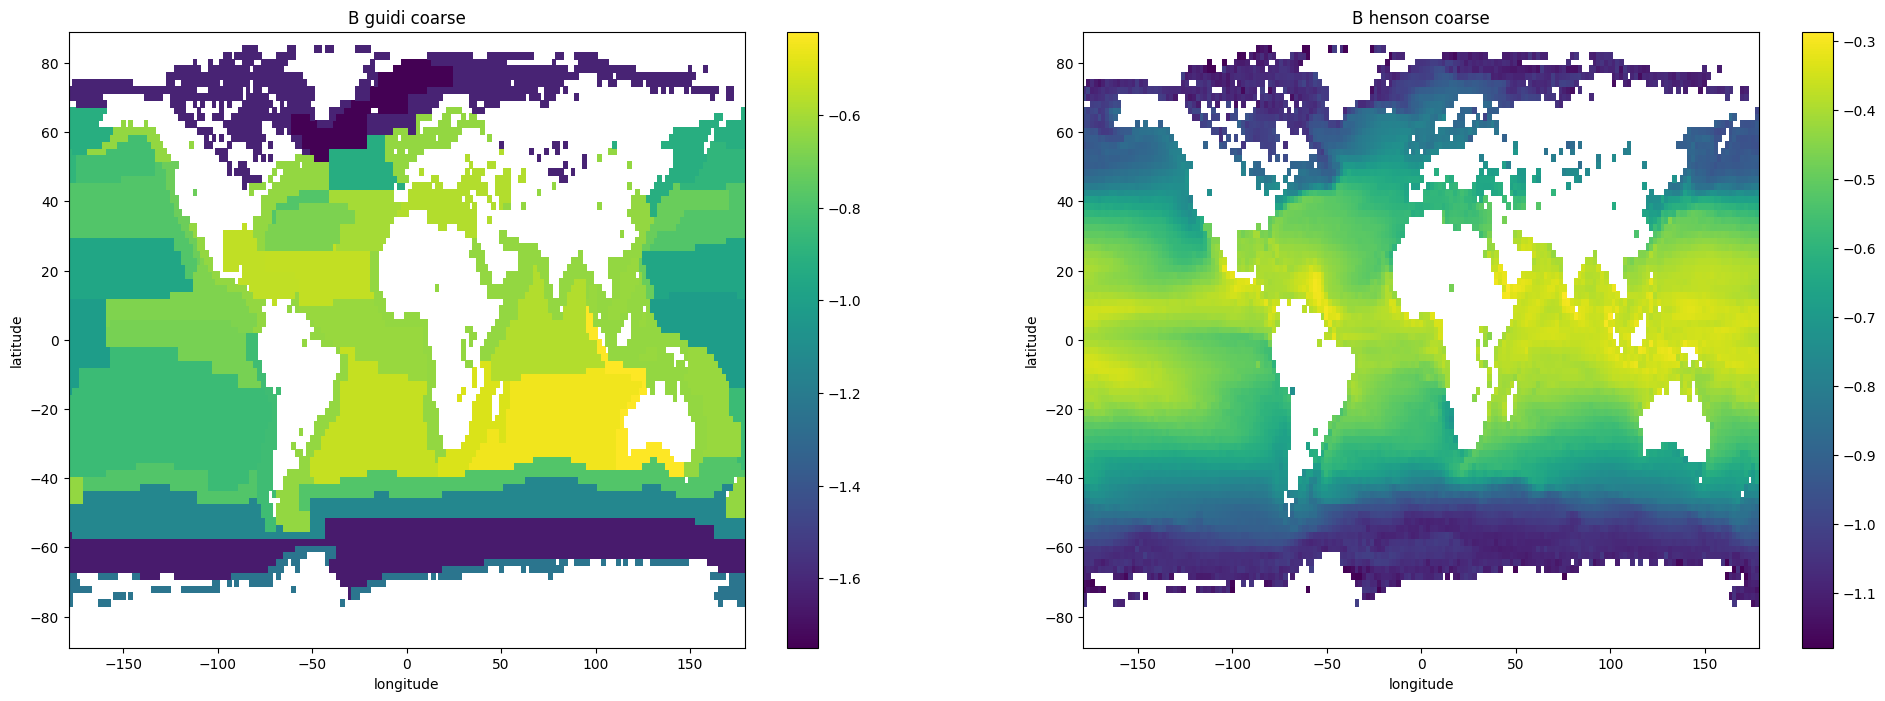

In [7]:
# plot results of coarser resolution on Henson and Guidi's data (b coefficient)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24,8))
im0 = ax0.pcolormesh(lonT, latT, b_guidi_coarse)
fig.colorbar(im0, ax=ax0)
ax0.set_title('B guidi coarse')
ax0.set_xlabel('longitude')
ax0.set_ylabel('latitude')

# henson
im1 = ax1.pcolormesh(lonT, latT, b_henson_coarse)
fig.colorbar(im1, ax=ax1)
ax1.set_title('B henson coarse')
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
plt.show()

In [8]:
# Martin's b coefficient on coarser grid (no need for interpolation because b is constant)
b_martin = np.zeros(b_guidi_coarse.shape) - 0.86

In [9]:
# prepare data for saving
b_data = dict({'b_martin':b_martin,'b_guidi':b_guidi_coarse,'b_henson':b_henson_coarse})

In [10]:
# save data in a pickle file
a_file = open("data/b_attenuation/b_data.pkl", "wb")
pickle.dump(b_data, a_file)
a_file.close()